In [ ]:
pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import bs4 as bs
import requests

In [3]:
plt.style.use('fivethirtyeight')

In [4]:

# Scrap sp500 tickers
def save_sp500_tickers():

    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))
        
    return tickers

tickers = save_sp500_tickers()

In [5]:
prices = yf.download(tickers, start='2020-01-01')['Adj Close']

[*********************100%***********************]  503 of 503 completed


In [6]:
prices.head(10)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,ALXN,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,...,VFC,VIAC,VLO,VMC,VNO,VNT,VRSK,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WLTW,WM,WMB,WMT,WRB,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,85.398193,28.982893,158.154831,74.573036,84.852608,83.938957,168.809998,85.600449,206.829712,334.429993,118.519348,44.922726,167.169968,187.830002,74.633308,91.241516,19.507826,52.246086,50.037643,49.053261,130.282578,94.271568,87.639999,71.596565,283.679993,67.785583,110.997246,124.238136,107.839996,61.554165,10.278079,49.099998,100.186646,235.229111,165.769714,225.507385,1898.010010,204.720001,259.589996,297.744690,...,98.148216,41.124256,90.956909,141.499435,62.789101,NaN,150.376770,196.729996,219.449997,53.591969,58.491680,80.508705,235.059998,57.253372,64.771545,88.815918,77.317070,51.909870,144.480637,202.071640,112.600060,22.021412,117.414719,68.562302,42.332024,151.352829,25.408863,29.037527,142.405029,61.184597,100.399811,67.240555,56.502354,35.372929,79.031929,100.691872,148.258896,259.140015,50.968010,133.542831
2020-01-03,84.027046,27.548195,158.164749,73.848030,84.047203,82.883308,166.820007,84.556908,206.485229,331.809998,116.432976,44.835045,166.816620,184.949997,74.662743,91.143898,19.283821,51.883739,49.650959,49.829113,130.902679,94.074158,87.239998,70.571083,280.440002,66.542633,111.007080,122.702377,106.410004,60.574444,10.142713,48.599998,100.325790,233.632172,163.702835,225.615936,1874.969971,200.850006,256.970001,293.796173,...,97.531288,40.498943,87.505264,140.884735,63.277992,NaN,151.839554,200.880005,217.979996,54.238224,57.868923,79.892082,231.009995,57.253372,63.774597,89.374260,78.677414,51.591164,142.018295,202.121109,113.694313,22.115158,116.378189,68.651772,41.581837,151.751816,25.321548,29.086929,140.292755,61.478848,98.088585,66.699974,55.877087,34.913166,79.497108,100.376495,147.871353,256.049988,50.248787,133.562759
2020-01-06,84.275452,27.219410,155.565384,74.436470,84.710480,84.096809,179.039993,84.999916,205.136902,333.709991,115.065033,44.484310,167.042374,187.119995,74.731445,91.446533,19.507826,51.736847,49.689625,50.139454,131.020798,94.508453,87.550003,70.492195,285.880005,66.224434,111.331757,122.474495,106.580002,59.268150,10.075031,48.389999,100.435127,235.425064,164.241592,225.556747,1902.880005,202.860001,254.589996,297.329071,...,97.149391,41.094948,87.514824,140.636887,64.102394,NaN,152.187836,202.740005,224.029999,54.798950,57.744373,79.563881,228.880005,57.747601,62.550629,89.442818,79.873734,51.282120,143.351669,202.368408,114.285797,22.405777,116.141258,68.552345,40.948559,151.831604,25.079004,29.027647,140.015091,61.390568,96.044044,67.212105,56.184761,34.386356,78.982445,100.317375,147.016785,258.010010,49.636467,132.537338
2020-01-07,84.533775,27.119778,153.720047,74.086395,84.227234,83.494980,180.350006,84.527367,200.707962,333.390015,117.682831,43.948479,165.020493,187.500000,75.006218,91.466057,19.576002,51.247192,49.409275,49.489674,130.134933,93.491814,90.199997,71.419083,283.059998,65.806808,110.377426,121.008080,106.849998,60.980186,9.988010,48.250000,101.011589,233.210892,162.262909,220.750519,1906.859985,204.850006,256.670013,296.428528,...,96.669571,41.163342,88.662186,139.050537,63.325916,NaN,153.461548,203.210007,223.789993,54.342773,57.102444,79.534050,231.979996,57.456879,66.785164,89.099983,79.352753,50.857185,143.400314,201.952957,114.364662,22.405777,115.065247,67.299622,40.490650,151.44259

In [7]:
rs = prices.apply(np.log).diff(1)

In [9]:
#choosing a dataset part to apply models

dftest = rs.iloc[:, 100:200]
dftest.dropna(inplace=True)
dftest

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,CMI,CMS,CNC,CNP,COF,COG,COO,COP,COST,CPB,CPRT,CRM,CSCO,CSX,CTAS,CTLT,CTSH,CTVA,CTXS,CVS,CVX,CXO,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISCA,DISCK,DISH,DLR,DLTR,DOV,DOW,DPZ,...,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FB,FBHS,FCX,FDX,FE,FFIV,FIS,FISV,FITB,FLIR,FLS,FLT,FMC,FOX,FOXA,FRC,FRT,FTI,FTNT,FTV,GD,GE,GILD,GIS,GL,GLW
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03,-0.014096,0.009676,-0.011704,-0.005955,-0.015661,0.002898,-0.003160,0.003660,0.000823,-0.001238,-0.008811,-0.004923,-0.016450,-0.004107,-0.004516,-0.011014,-0.009085,-0.011901,0.001342,-0.007988,-0.003465,0.036696,-0.002443,-0.016738,-0.021328,-0.007435,-0.016787,-0.007373,-0.005881,0.007391,-0.006209,-0.011537,-0.005914,-0.005647,0.003910,0.016307,-0.008030,-0.009370,-0.025055,0.004319,...,-0.004455,0.009742,-0.007433,0.006761,-0.006438,0.000945,-0.003749,0.003077,-0.006145,-0.016810,0.016947,-0.022545,0.018818,-0.017887,-0.005305,-0.006402,-0.030772,-0.012457,-0.001474,-0.005414,-0.006310,0.007331,-0.018875,-0.000948,-0.015911,0.010613,-0.006529,-0.009923,-0.010985,-0.002631,0.006841,0.011652,0.013853,-0.004135,0.009760,0.003347,-0.002456,-0.003651,-0.012008,-0.013090
2020-01-06,-0.015273,0.004484,0.030117,-0.001494,-0.009061,0.008069,0.002696,0.011802,0.000274,0.001650,0.008918,0.042878,0.003563,-0.005227,0.002593,0.000179,-0.009991,-0.001409,0.010586,0.003934,-0.003394,0.018998,0.007676,-0.006913,-0.007104,0.007152,-0.017802,-0.003424,0.005408,0.008461,0.002980,-0.005819,-0.002188,-0.002001,-0.006711,-0.009045,0.000000,0.000086,-0.004014,-0.002446,...,0.005416,-0.003992,0.001890,0.003531,-0.001449,-0.002839,0.013593,0.001535,-0.013446,-0.003580,-0.000657,-0.005444,0.005177,-0.015709,0.018658,0.007617,0.003899,0.000783,0.001895,-0.012579,0.009521,0.004801,-0.008247,-0.000570,-0.002007,-0.005586,-0.008806,-0.002357,-0.002594,-0.012399,0.011743,0.006927,0.007079,-0.005193,0.010545,0.014102,0.008874,0.012437,-0.005287,0.002699
2020-01-07,0.000746,-0.005126,0.000000,0.004476,-0.009942,0.005724,0.002719,0.000000,-0.001578,0.000623,-0.001284,0.014595,-0.006506,0.006735,-0.000740,0.005344,-0.007103,0.003871,-0.005323,-0.003798,-0.012852,0.012754,-0.002187,-0.000868,-0.015512,-0.017516,-0.011105,-0.015192,-0.011516,-0.003752,0.009783,0.000343,0.003436,0.001001,-0.002810,-0.009892,-0.011895,0.002760,-0.000383,-0.007170,...,-0.007591,-0.012309,-0.005258,-0.000168,0.020858,0.000632,-0.007653,0.000876,-0.002607,0.011702,-0.004519,0.009777,0.015890,-0.001946,0.002161,-0.005021,0.015444,0.009737,-0.000631,-0.009156,-0.015510,-0.003856,-0.011326,0.000570,-0.001407,0.008813,0.018035,0.012555,0.013580,-0.005176,-0.018026,-0.024221,-0.000983,0.003249,-0.011433,-0.007441,-0.008106,-0.006869,-0.000964,0.007385
2020-01-08,0.000516,-0.000321,0.021037,-0.008597,0.010536,-0.038993,0.011048,-0.023437,0.011399,-0.017585,0.006831,0.007528,0.000632,0.005192,0.019108,0.006905,0.006774,0.008046,0.011938,-0.012582,-0.011489,-0.024462,-0.006345,0.021296,0.011941,0.012356,0.010741,-0.004346,0.004108,0.005435,0.001024,-0.002061,0.001247,0.005321,-0.001408,0.008629,-0.023554,0.002323,0.010294,-0.004430,...,0.000846,0.005754,0.003053,-0.001428,-0.017074,0.001892,-0.006674,0.007198,-0.003268,-0.012807,0.001980,0.000000,-0.032572,0.007487,0.010087,0.018588,0.009912,0.014940,0.002102,-0.004023,0.014583,0.002743,0.002342,0.017493,0.010008,0.017902,0.002991,-0.001372,0.001078,0.004057,0.003345,-0.034536,0.015783,-0.000909,0.002552,-0.009171,0.010388,0.014258,-0.000483,0.004671
2020-01-09,-0.004772,0.007681,-0.003268,-0.007158,0.013455,0.024041,0.016947,0.017251,0.015923,0.005686,0.013524,0.012720,-0.004218,0.004894,0.014677,0.005103,0.006238,0.001045,0.002546,0.002749,-0.001616,-0.005629,0.002812,0.001867,-0.008983,0.009618,0.012787,0.006773,0.012222,-0.004308,0.008791,-0.003928,0.004351,0.002981,0.002533,0.000084,0.014045,0.006338,-0.010294,-0.005730,...,0.007824,0.004753,0.000631,0.010869,0.031172,0.009407,0.010572,0.003038,0.005614,0

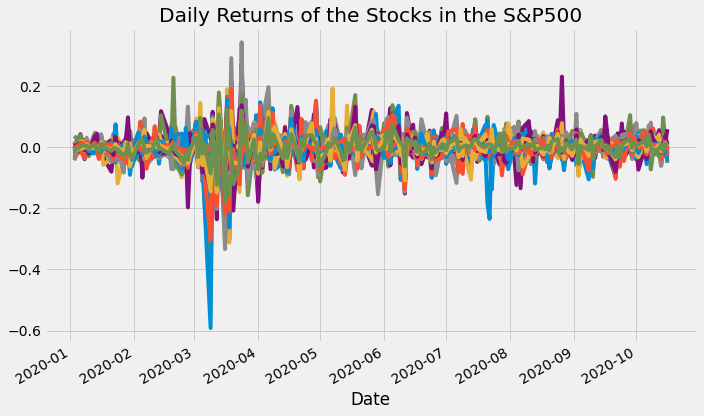

In [11]:
#Visualizing our dataframe
dftest.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks in the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

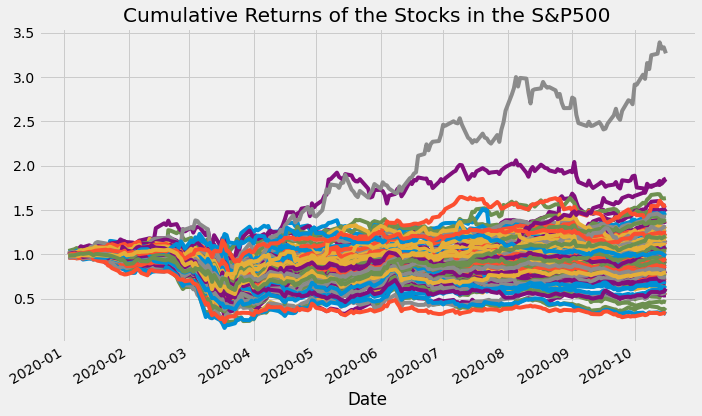

In [12]:
#Show cumulative returns of the stocks in the S&P500
(dftest.cumsum().apply(np.exp)).plot(legend=0, figsize=(10,6), grid=True, title='Cumulative Returns of the Stocks in the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

In [13]:
from sklearn.decomposition import PCA

In [15]:
#Applying PCA
pca = PCA(1).fit(dftest.fillna(0))

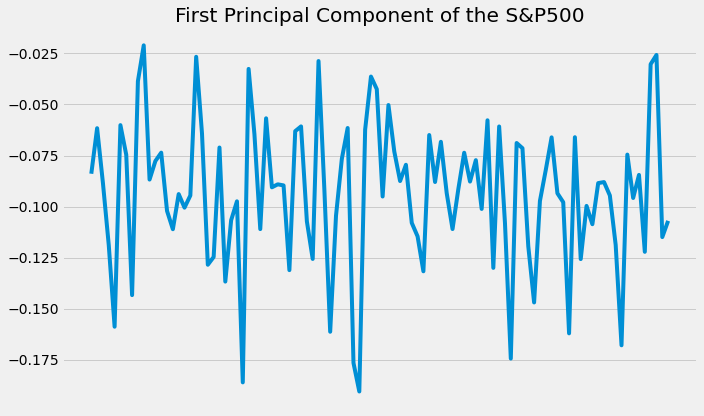

In [16]:
pc1 = pd.Series(index=dftest.columns, data=pca.components_[0])

pc1.plot(figsize=(10,6), xticks=[], grid=True, title='First Principal Component of the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

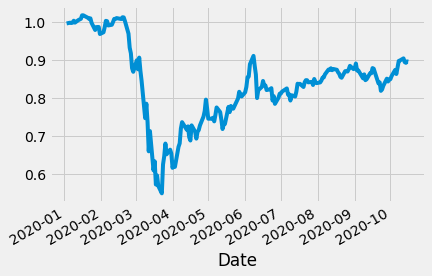

In [17]:
weights = abs(pc1)/sum(abs(pc1))
myrs = (weights*dftest).sum(1)
myrs.cumsum().apply(np.exp).plot()

In [18]:
WHPCA = weights.to_frame().T
WHPCA

,CMI,CMS,CNC,CNP,COF,COG,COO,COP,COST,CPB,CPRT,CRM,CSCO,CSX,CTAS,CTLT,CTSH,CTVA,CTXS,CVS,CVX,CXO,D,DAL,DD,DE,DFS,DG,DGX,DHI,DHR,DIS,DISCA,DISCK,DISH,DLR,DLTR,DOV,DOW,DPZ,...,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FB,FBHS,FCX,FDX,FE,FFIV,FIS,FISV,FITB,FLIR,FLS,FLT,FMC,FOX,FOXA,FRC,FRT,FTI,FTNT,FTV,GD,GE,GILD,GIS,GL,GLW
0,0.008992,0.006603,0.009486,0.012745,0.017021,0.006441,0.007997,0.015362,0.004137,0.002254,0.009297,0.008325,0.007886,0.010943,0.011905,0.01006,0.010772,0.010133,0.002855,0.00688,0.013769,0.013362,0.007617,0.014652,0.011433,0.010441,0.019941,0.003491,0.006921,0.011898,0.006083,0.009705,0.009549,0.009604,0.014051,0.006758,0.006508,0.011489,0.013464,0.003077,...,0.007317,0.01001,0.011894,0.009786,0.007891,0.009404,0.008278,0.010839,0.006187,0.013933,0.006512,0.011585,0.018692,0.00738,0.007652,0.012799,0.015747,0.010419,0.008797,0.007083,0.010018,0.010488,0.017369,0.007075,0.013471,0.01068,0.011642,0.009483,0.00943,0.010133,0.012729,0.017996,0.007988,0.010264,0.009054,0.01309,0.003245,0.002758,0.012316,0.011465


In [19]:
prices = yf.download(['SPY'], start='2020-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed


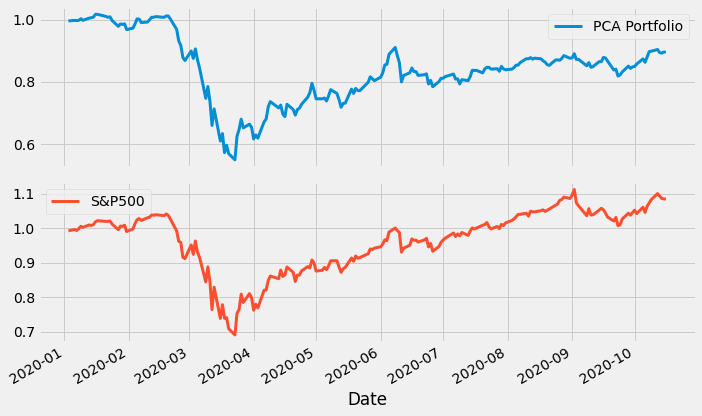

In [20]:

rs_df = pd.concat([myrs, prices.apply(np.log).diff(1)], 1)
rs_df.columns = ["PCA Portfolio", "S&P500"]

rs_df.dropna().cumsum().apply(np.exp).plot(subplots=True, figsize=(10,6), grid=True, linewidth=3);
plt.tight_layout()
plt.savefig('tmp.png')

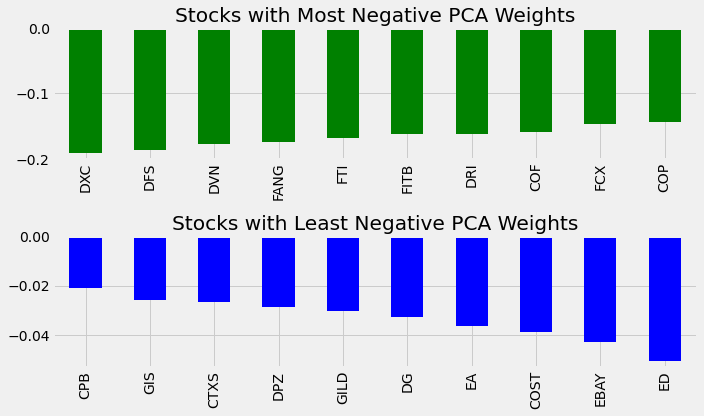

In [21]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1.nsmallest(10).plot.bar(ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')

plt.tight_layout()
plt.savefig('tmp.png')

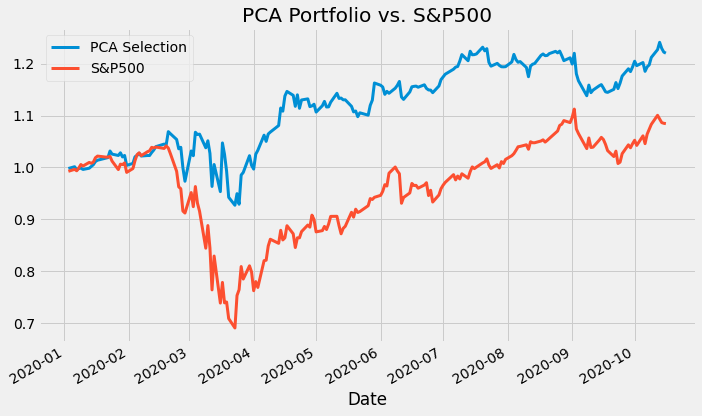

In [22]:

myrs = dftest[pc1.nlargest(10).index].mean(1)
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
prices['2020':].apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()
plt.savefig('tmp.png')

In [ ]:
pip install mlfinlab

AxesSubplot(0.08,0.07;0.87x0.81)


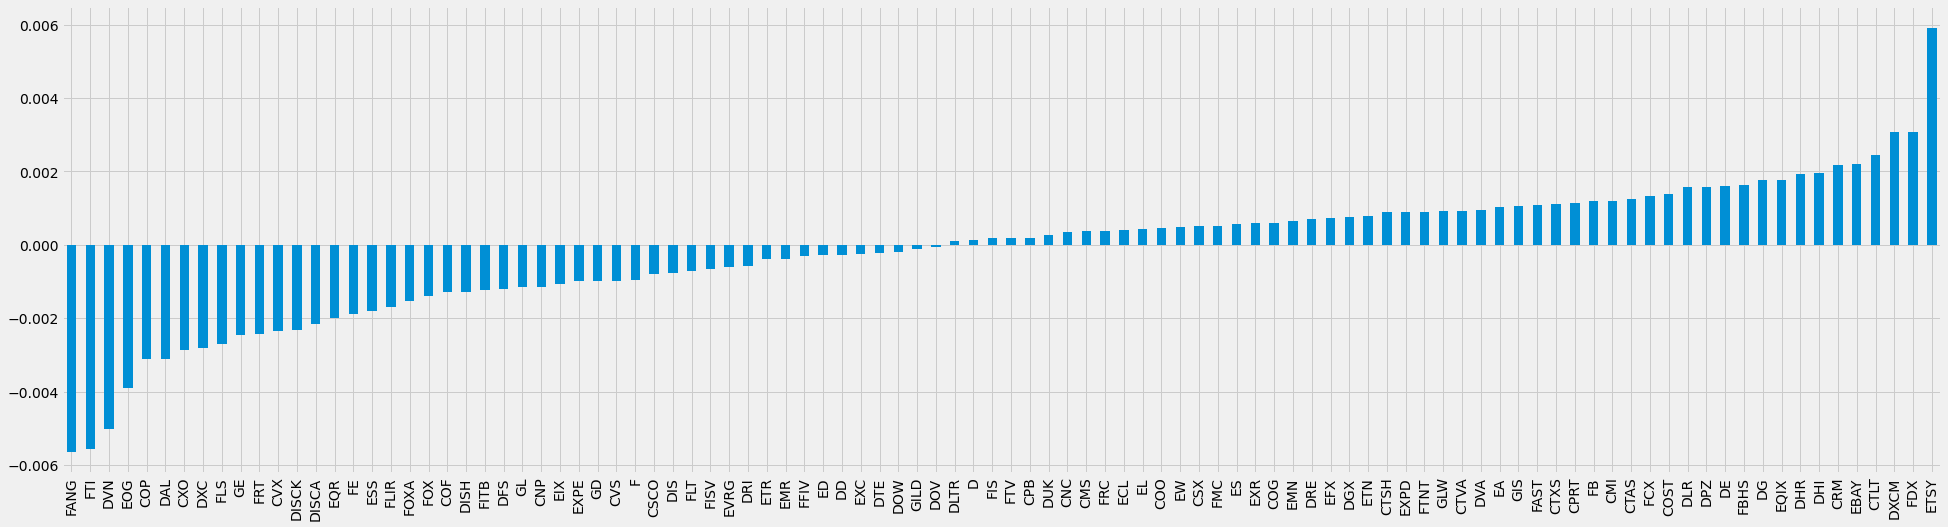

In [24]:
print((dftest.mean().sort_values().plot.bar(figsize=(30,8))))

In [25]:
# importing our required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlfinlab.portfolio_optimization import HierarchicalRiskParity

In [26]:
# constructing our HRP portfolio - Single Linkage
hrp = HierarchicalRiskParity()
hrp.allocate(asset_names=dftest.columns,
             asset_prices=dftest,
             linkage='single')

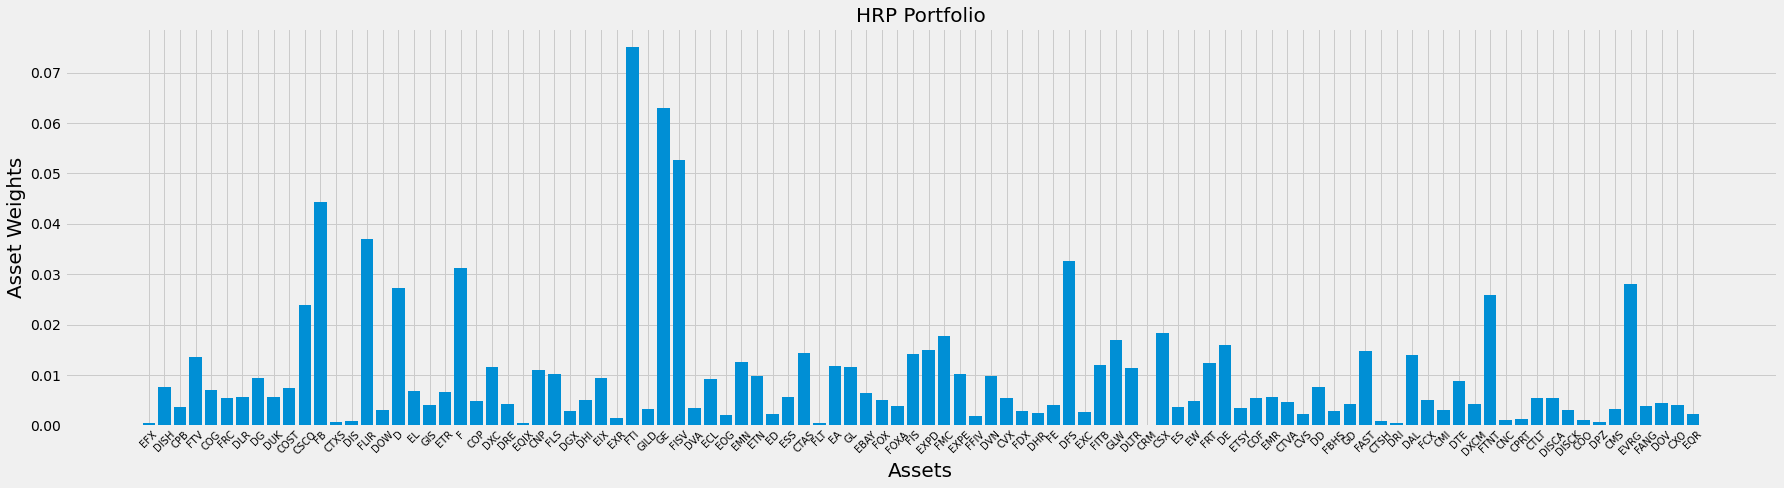

In [27]:
# plotting our optimal portfolio
hrp_weights = hrp.weights
y_pos = np.arange(len(hrp_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(hrp_weights.columns), hrp_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP Portfolio', size=20)
plt.tight_layout()
plt.savefig('HRP Portfolio Weights')
plt.show()

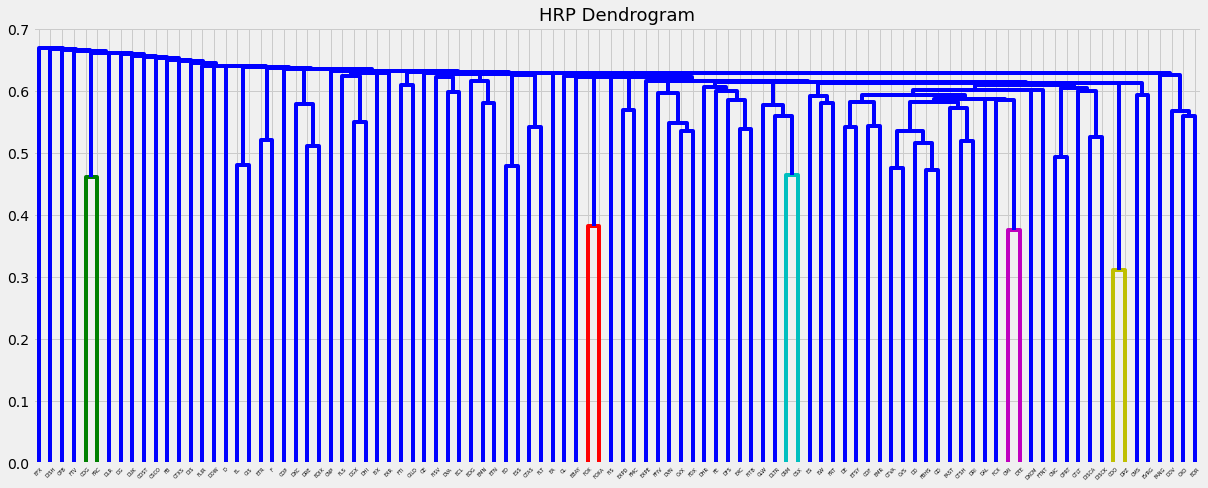

In [28]:
# plotting dendrogram of HRP portfolio
plt.figure(figsize=(17,7))
hrp.plot_clusters(dftest.columns)
plt.title('HRP Dendrogram', size=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

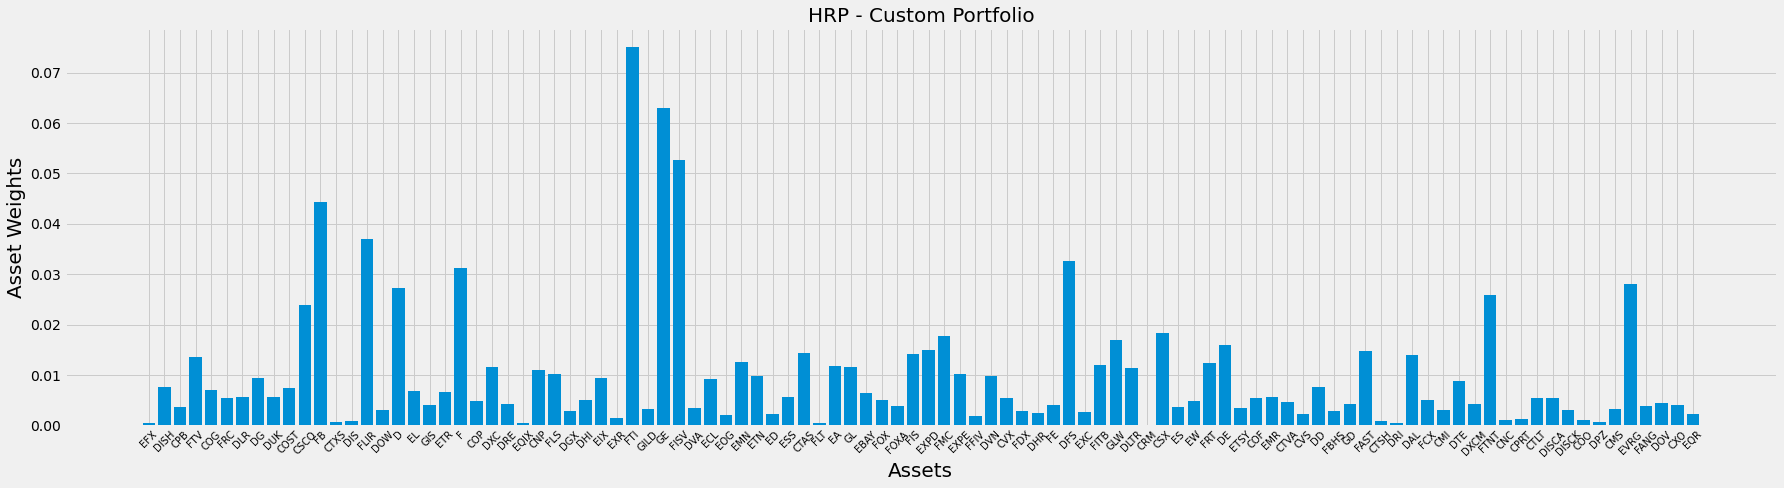

In [29]:
# importing ReturnsEstimation class from MlFinLab
from mlfinlab.portfolio_optimization.returns_estimators import ReturnsEstimators
# calculating our asset returns
returns = ReturnsEstimators.calculate_returns(dftest)
# calculating our covariance matrix
cov = returns.cov()
# constructing our first custom portfolio
hrp_custom = HierarchicalRiskParity()
hrp_custom.allocate(asset_names=dftest.columns,
                    asset_returns=returns,
                    covariance_matrix=cov)
# plotting our optimal portfolio
hrp_custom_weights = hrp_custom.weights
y_pos = np.arange(len(hrp_custom_weights.columns))
plt.figure(figsize=(25,7))
plt.bar(list(hrp_custom_weights.columns), hrp_custom_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Custom Portfolio', size=20)
plt.tight_layout()
plt.show()

In [31]:
hrp_custom_weights 

,EFX,DISH,CPB,FTV,COG,FRC,DLR,DG,DUK,COST,CSCO,FB,CTXS,DIS,FLIR,DOW,D,EL,GIS,ETR,F,COP,DXC,DRE,EQIX,CNP,FLS,DGX,DHI,EIX,EXR,FTI,GILD,GE,FISV,DVA,ECL,EOG,EMN,ETN,...,EXC,FITB,GLW,DLTR,CRM,CSX,ES,EW,FRT,DE,ETSY,COF,EMR,CTVA,CVS,DD,FBHS,GD,FAST,CTSH,DRI,DAL,FCX,CMI,DTE,DXCM,FTNT,CNC,CPRT,CTLT,DISCA,DISCK,COO,DPZ,CMS,EVRG,FANG,DOV,CXO,EQR
0,0.000477,0.007713,0.003707,0.013531,0.007052,0.005398,0.005743,0.009407,0.005582,0.007541,0.023902,0.044389,0.000799,0.000983,0.036932,0.003098,0.02729,0.006928,0.00408,0.006708,0.031168,0.004914,0.011597,0.004335,0.000484,0.011052,0.010217,0.002905,0.005044,0.009432,0.001567,0.075068,0.003318,0.062917,0.052706,0.003553,0.009142,0.002017,0.012513,0.009809,...,0.002628,0.011972,0.017051,0.011341,0.000063,0.018346,0.003748,0.00489,0.012445,0.016023,0.003476,0.005406,0.005714,0.004769,0.002245,0.007679,0.002892,0.004355,0.014759,0.000854,0.000468,0.013995,0.005022,0.003128,0.008782,0.004361,0.025969,0.001054,0.001348,0.005534,0.005539,0.003149,0.001089,0.000699,0.003214,0.028054,0.003969,0.004406,0.004068,0.002281


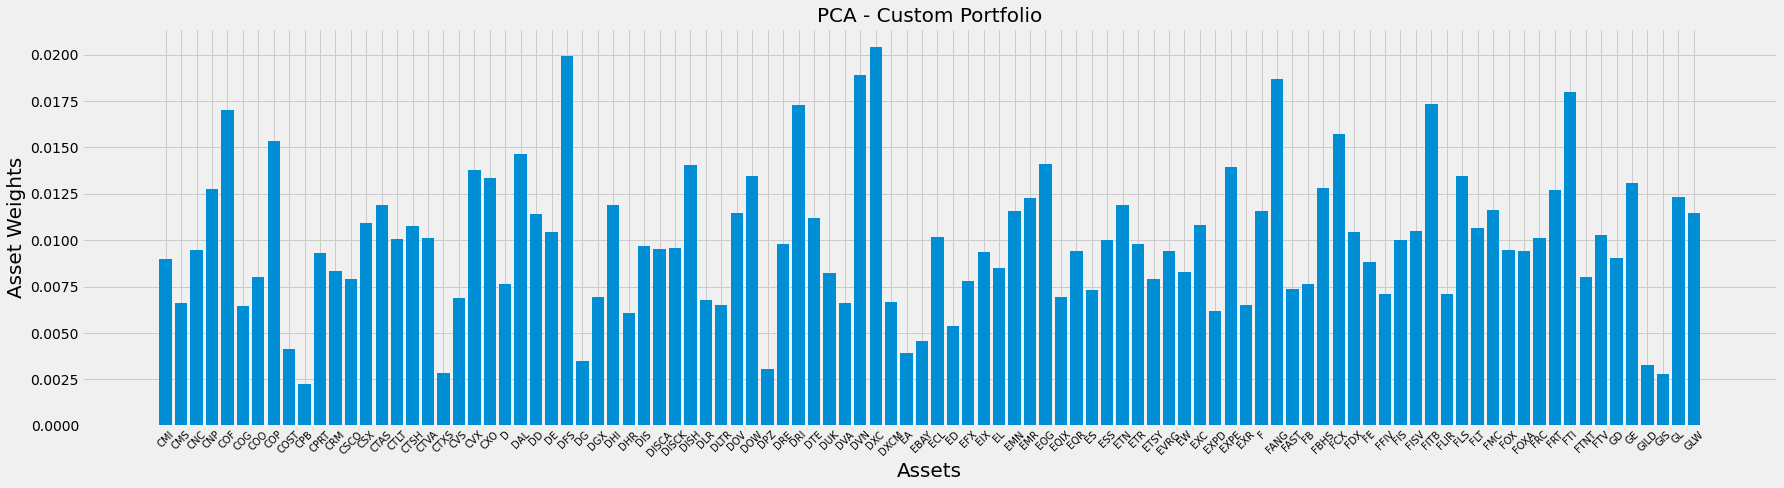

In [30]:
# plotting our PCA optimal portfolio 

y_pos = np.arange(len(WHPCA.columns))
plt.figure(figsize=(25,7))
plt.bar(list(WHPCA.columns), WHPCA.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('PCA - Custom Portfolio', size=20)
plt.tight_layout()
plt.show()